In [0]:
!unzip 'DeepFakes.zip'; mv ManipulatedRes DeepFakes
!unzip 'OriginalDeepFakes.zip'; mv  DeepFakesRes OriginalDeepFakes
!unzip 'FaceSwap.zip'; mv ManipulatedRes FaceSwap
!unzip 'OriginalFaceSwap.zip'; mv  FaceSwapRes OriginalFaceSwap
!unzip 'NeuralTextures.zip'; mv ManipulatedRes NeuralTextures
!unzip 'OriginalNeuralTextures.zip'; mv  NeuralTexturesRes OriginalNeuralTextures
!unzip 'Face2Face.zip'; mv ManipulatedRes Face2Face
!unzip 'OriginalFace2Face.zip'; mv  Face2FaceRes OriginalFace2Face
!python3 -m pip install libsvm

# Common imports
import os
import numpy as np
import pandas as pd

Feature computation and extration. 

In [0]:
import cv2 as cv
from sklearn.cluster import MiniBatchKMeans
from skimage.feature import greycomatrix, greycoprops

# Algo related 
KSIZE = 21 
CMAX = 256
FLT = cv.CV_32F
QUANTIZATION_STEP = 5 			# Range [0, 255]
TRUNC_UPPER_THRESHOLD = 2		# Cutoff for residual vals
GLCM_STRIDE = [1]       		# Pel distance for GLCM
GLCM_DIRECTIONS = [0, np.pi / 2, 2 * np.pi / 3, 4 * np.pi / 3]

# Flags
ShouldApplyFaceMask = True 

filters = {
"laplacian" : lambda x: cv.Laplacian(x, FLT),
"sobel-x": lambda x: cv.Sobel(x, FLT, 1, 0, ksize = KSIZE),
"sobel-y": lambda x: cv.Sobel(x, FLT, 0, 1, ksize = KSIZE),
"gabor": lambda x: cv.filter2D(x, FLT, cv.getGaborKernel((KSIZE, KSIZE), 8.0, np.pi/4, 10.0, 0.5, 0, ktype=FLT))
}

class GLCM_METRIC_NAMES:
    count = 4             # tmp, but bad idea...
		dis = "dissimilarity" 
		con = "contrast"
		cor = "correlation"
		hom = "homogeneity"

def LoadMask(image_path):
        if (not os.path.exists(image_path)):
                print("Failed to load image '{}'".format(image_path))
                return None

        return cv.imread(image_path, 0)
  
def LoadImage(image_path):
        if (not os.path.exists(image_path)):
                print("Failed to load image '{}'".format(image_path))
                return None

        return cv.imread(image_path)

def IsMatNone(image):
        return isinstance(image, type(None))

def Normalize(image, should_use_flt=False):
        return cv.normalize(image, None, 0, 1, norm_type=cv.NORM_MINMAX, dtype=FLT)\
        if (should_use_flt) else cv.normalize(image, None, 0, 255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

def ToFeatureVec(image):
        assert not IsMatNone(image), "Image type is None"
        return image.reshape(image.shape[0] * image.shape[1], image.shape[2])

def ComputeResidualImage(image, filterName, shouldApplyQT=True):
        assert not IsMatNone(image), "no image"

        # 1) quantize pels - Rq_ij = round( Rij / q_step )
        # NOTE: Temporarily cvt to LAB color space (Lightness, Alpha=[G,M], Beta=[B,Y])
        # to yield ftr vector representing euclidean dists for k-means quantization
        res_image = filters[filterName](image)
        if (not shouldApplyQT):
            return res_image 

        input_ftr = ToFeatureVec(cv.cvtColor(Normalize(res_image), cv.COLOR_BGR2LAB))
        kmc = MiniBatchKMeans(n_clusters = 255 // QUANTIZATION_STEP)
        labels = kmc.fit_predict(input_ftr)
        quantized_image = kmc.cluster_centers_.astype("uint8")[labels]  
        # Cvt back to RGB color space
        quantized_image = quantized_image.reshape(res_image.shape)
        quantized_image = cv.cvtColor(quantized_image, cv.COLOR_LAB2BGR)
        assert(not IsMatNone(quantized_image)), "no quantized image"

        # 2) truncate pels - truncate( Rq_ij, T )
        ret,truncated_image = cv.threshold(quantized_image, TRUNC_UPPER_THRESHOLD, CMAX - 1, cv.THRESH_TRUNC)
        return cv.cvtColor(truncated_image, cv.COLOR_BGR2GRAY)

def ComputeCoOccurrance(res_image_grey, patch_size):
		assert not IsMatNone(res_image_grey), "no residual image"
		patches = []
		for x in range(0, res_image_grey.shape[0], patch_size):
			for y in range(0, res_image_grey.shape[1], patch_size):
				p = np.array(res_image_grey[x : x + patch_size, y : y + patch_size])
				patches.append(p)

		dissim = []
		corr = []
		homogen = []
		contrast = []
		for p in patches:
			glcm = greycomatrix(p[0], GLCM_STRIDE, GLCM_DIRECTIONS, symmetric=True, normed=True)
			dissim.append(greycoprops(glcm, 'dissimilarity'))
			corr.append(greycoprops(glcm, 'correlation'))
			homogen.append(greycoprops(glcm, 'homogeneity'))
			contrast.append(greycoprops(glcm, 'contrast'))

		# stats per patch
		return {GLCM_METRIC_NAMES.dis: dissim, GLCM_METRIC_NAMES.cor: corr, 
		        GLCM_METRIC_NAMES.hom: homogen, GLCM_METRIC_NAMES.con: contrast }

In [0]:
TEST_SINGLE_PASS = False
FRAME_FILE_EXT = ".png"
LOG_FILENAME = "ImageProc.txt"
PATCH_SIZE = 64

def LoadPreProcFrames(frames_path, filterName):
    frame_files = [x for x in os.listdir(frames_path) if FRAME_FILE_EXT in x and filterName in x]
    frame_files.sort()
    if TEST_SINGLE_PASS and len(frame_files) > 5:
        frame_files = frame_files[:5]

    # Contains a dictionary whose len is the number of frames and
    # keys are stat-types and values are stat for each patch in frame 
    features_dict = []
    for frame_file in frame_files:
        preproc_frame = LoadImage(os.path.join(frames_path, frame_file))
        assert not IsMatNone(preproc_frame), "no frame available for '{}'".format(frame_file)
        features_dict.append(ComputeCoOccurrance(preproc_frame, PATCH_SIZE))

    return features_dict

IMAGE_ROOT_PATH = ""
OUTPUT_FIG_DIR = ""

def Run(fakeDataDirName, originalDataDirName, filterName, shouldUseCachedFrames):
    real_data_path = os.path.join(IMAGE_ROOT_PATH, originalDataDirName)
    fake_data_path = os.path.join(IMAGE_ROOT_PATH, fakeDataDirName)

    if (not os.path.exists(real_data_path) 
        and not os.path.exists(fake_data_path)):
        print("Failed to find expected folders under '{}'".format(IMAGE_ROOT_PATH))
        return []

    print("Processing frames for '{}' and '{}'".format(originalDataDirName, fakeDataDirName))
    r_feature_dicts = LoadPreProcFrames(real_data_path, filterName)
    f_feature_dicts = LoadPreProcFrames(fake_data_path, filterName)

    if (len(r_feature_dicts) == 0 or len(f_feature_dicts) == 0):
        print("processed frames count: real={}, fake={}".format(len(r_feature_dicts), len(f_feature_dicts)))
        return []
    else:
        # ftr dict count = # patches * # images
        print("real ftr count={}\nfake ftr count={}".format(len(r_feature_dicts), len(f_feature_dicts)))
        print("Finished.")

    return [r_feature_dicts, f_feature_dicts]

Processing frames for 'OriginalDeepFakes' and 'DeepFakes'
real ftr count=390
fake ftr count=390
Finished.


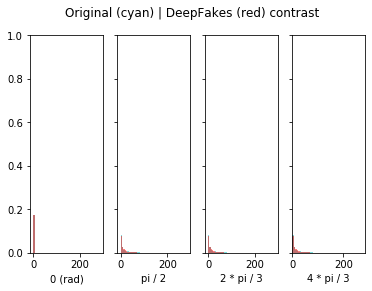

In [83]:
import numpy as np
from matplotlib import pyplot as plt
FILTER_NAME = "sobel-x"
METRIC_NAME = GLCM_METRIC_NAMES.con

# Outputs list of patch glcm stats along m directions
def SerializeAsArray(coo_features, dict_key):
	x = []
	for frame_metrics in coo_features:
		for p in frame_metrics[dict_key]:
			x.append(p)
	return np.array(x)

def PlotPatchStatsHist(coo_features, metric_name, name0, name1):
	data_arr0 = SerializeAsArray(coo_features[0], metric_name)
	data_arr1 = SerializeAsArray(coo_features[1], metric_name)

	xmax = (int)(max(data_arr0.max(), data_arr1.max()))
	bins = np.linspace(-0.1, xmax, 50)
	# Why does this line generate indentation error??
	# f, ax = plt.subplots(1, 4, sharey=True)
	f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, sharey=True)
	f.suptitle("{} (cyan) | {} (red) {}".format(name0, name1, metric_name))
	# TODO: plot shared xy labels
	xlabel = "glcm: " + metric_name
	ylabel = "normalized patch cnt ({}|{})".format(len(coo_features[0]),len(coo_features[1]))
	plt.xlim(-0.1, xmax)
	plt.ylim(0, 1)
 
	ax0.hist(data_arr0[:,:,0], bins=bins, alpha=0.5, color='c', density=True, histtype="stepfilled", stacked=True)
	ax0.set_xlabel("0 (rad)")
	ax1.hist(data_arr0[:,:,1], bins=bins, alpha=0.5, color='c', density=True, histtype="stepfilled", stacked=True)
	ax1.set_xlabel("pi / 2")
	ax2.hist(data_arr0[:,:,2], bins=bins, alpha=0.5, color='c', density=True, histtype="stepfilled", stacked=True)
	ax2.set_xlabel("2 * pi / 3")
	ax3.hist(data_arr0[:,:,3], bins=bins, alpha=0.5, color='c', density=True, histtype="stepfilled", stacked=True)
	ax3.set_xlabel("4 * pi / 3")
 
	ax0.hist(data_arr1[:,:,0], bins=bins, alpha=0.5, color='r', density=True, histtype="stepfilled", stacked=True)
	ax1.hist(data_arr1[:,:,1], bins=bins, alpha=0.5, color='r', density=True, histtype="stepfilled", stacked=True)
	ax2.hist(data_arr1[:,:,2], bins=bins, alpha=0.5, color='r', density=True, histtype="stepfilled", stacked=True)
	ax3.hist(data_arr1[:,:,3], bins=bins, alpha=0.5, color='r', density=True, histtype="stepfilled", stacked=True)
	
	plt.show()
	f.savefig("{}_vs_{}_{}".format(name0, name1, metric_name))
	return

coo_features = Run("DeepFakes", "OriginalDeepFakes", FILTER_NAME, True)

# Histogram of metrics
PlotPatchStatsHist(
		coo_features,
		METRIC_NAME,
		"Original",
		"DeepFakes"
)

In [0]:
from libsvm.svmutil import * 
from timeit import default_timer as timer
from numpy import random

TRAIN_PCT_SAMP_SIZE = 0.7
ShouldTestFullDataset = False
LABEL_IDX = 0
DATA_IDX = 1

class SvmOutputs:
    def __init__(self, model, metric, labels, accuracy, label_confidence):
      self.model = model
      self.metric = metric
      self.accuracy = accuracy
      self.labels = labels
      self.label_confidence = np.array(label_confidence)

"""
Outputs dictionary of id to patch glcm stats along m directions.
The input format expected by svm_read_problem is as follows
<label_0> <index_0>:<value> ... <index_M>:<value>
    ...
<label_N> <index_0>:<value> ... <index_M>:<value>

For N training data points with M-dimensional features. This 
file format is parsed into a list of labels and corresponding 
input data. Each input data is represented as a dictionary, where
each dimension index and value are used as the key and value, resp.
Kind of a strange representation to use for numerical data...
"""
def SerializeAsDict(frame_metrics, dict_key=""):
    x = {}
    i = 0
    if (dict_key == ""):
            for k in frame_metrics:
                for patch in frame_metrics[k]:
                    for d in patch[0]:
                        x[i] = d
                        i += 1
    else:
            for patch in frame_metrics[dict_key]:
                for d in patch[0]:
                    x[i] = d
                    i += 1
    return x

def TrainAndTestSvm(coo_features, glcm_metric, dataset_name):
    print("Train and test using '{}' and '{}'".format(dataset_name, glcm_metric))
    real_feature_vec = [SerializeAsDict(f, glcm_metric) for f in coo_features[0]]
    fake_feature_vec = [SerializeAsDict(f, glcm_metric) for f in coo_features[1]]

    data_set = np.array([[1,f] for f in real_feature_vec] + [[-1,f] for f in fake_feature_vec])
    random.shuffle(data_set)

    # TODO: tune svm params (https://www.csie.ntu.edu.tw/~cjlin/libsvm/)
    # use xval to find good C
    # consider kernels and xval to find good params

    print("--- Train ---")
    train_samp_size = int(TRAIN_PCT_SAMP_SIZE * len(data_set))
    train_data = data_set[:,DATA_IDX][:train_samp_size]
    train_labels = data_set[:,LABEL_IDX][:train_samp_size]
    print("train data size: {}".format(len(train_data)))

    start = timer()
    model = svm_train(train_labels, train_data, '-c 4 -b 0')
    print("elapsed time (s): {} ".format(timer() - start))

    print("--- Eval ---")
    test_samp_size = len(data_set) - train_samp_size
    if (ShouldTestFullDataset):
        test_data = data_set[:,DATA_IDX][:]
        test_labels = data_set[:,LABEL_IDX][:]
    else:
        test_data = data_set[:,DATA_IDX][train_samp_size:]
        test_labels = data_set[:,LABEL_IDX][train_samp_size:]
    print("test data size: {}".format(len(test_data)))
    # label:    predicted class
    # acc:      100 * (1 - misclassifications/N)
    # val:      prob of choosing predicted class
    start = timer()
    p_label, p_acc, p_val = svm_predict(test_labels, test_data, model)
    print("elapsed time (s): {} ".format(timer() - start))
    return SvmOutputs(model, glcm_metric, p_label, p_acc, p_val)

def TestSvm(coo_features_dict, glcm_metric, excluded_dataset_name):
    print("Train and test using all except'{}' with metric '{}'".format(excluded_dataset_name, glcm_metric))
    real_feature_vec = []
    fake_feature_vec = []
    for dataset in coo_features_dict:
      if (dataset != excluded_dataset_name):
        real_feature_vec += [SerializeAsDict(f, glcm_metric) for f in coo_features[0]]
        fake_feature_vec += [SerializeAsDict(f, glcm_metric) for f in coo_features[1]]

    data_set = np.array([[1,f] for f in real_feature_vec] + [[-1,f] for f in fake_feature_vec])
    random.shuffle(data_set)

Process **individual** datasets with various glcm metrics.

In [0]:
FILTER_NAME = "sobel-x"
dataset_feature_dict = {}
dataset_feature_dict["DeepFakes"] = Run("DeepFakes", "OriginalDeepFakes", FILTER_NAME, True)
dataset_feature_dict["FaceSwap"] = Run("FaceSwap", "OriginalFaceSwap", FILTER_NAME, True)
dataset_feature_dict["Face2Face"] = Run("Face2Face", "OriginalFace2Face", FILTER_NAME, True)
dataset_feature_dict["NeuralTextures"] = Run("NeuralTextures", "OriginalNeuralTextures", FILTER_NAME, True)

# Contains svm outputs indexed by dataset name
dataset_model_dict = {}
for dn in ["DeepFakes", "FaceSwap", "Face2Face", "NeuralTextures"]:
  dataset_model_dict[dn] = []
  dataset_model_dict[dn].append(TrainAndTestSvm(dataset_feature_dict[dn], GLCM_METRIC_NAMES.con, dn))
  dataset_model_dict[dn].append(TrainAndTestSvm(dataset_feature_dict[dn], GLCM_METRIC_NAMES.cor, dn))
  dataset_model_dict[dn].append(TrainAndTestSvm(dataset_feature_dict[dn], GLCM_METRIC_NAMES.dis, dn))
  dataset_model_dict[dn].append(TrainAndTestSvm(dataset_feature_dict[dn], GLCM_METRIC_NAMES.hom, dn))


Train on collection of datasets with various glcm metrics.

Train on single dataset and test on others.

Save results to file.

In [91]:
logtxt = "dataset,metric,accuracy,mse,sq_corr_coeff\n"
print(len(dataset_model_dict))
for k in dataset_model_dict:
  for result in dataset_model_dict[k]:
    logtxt += "{},{},{},{},{}".format(k, result.metric, result.accuracy[0],result.accuracy[1], result.accuracy[2])
    logtxt += "\n"

logfile = open("data.txt","w")
logfile.write(logtxt)

# read results
#data_file = "data.txt"
#results = np.genfromtxt(data_file, delimiter=',', dtype=None, names=('dataset','metric','accuracy','mse','sq_corr_coeff'))


4


1307

Show and save plots.

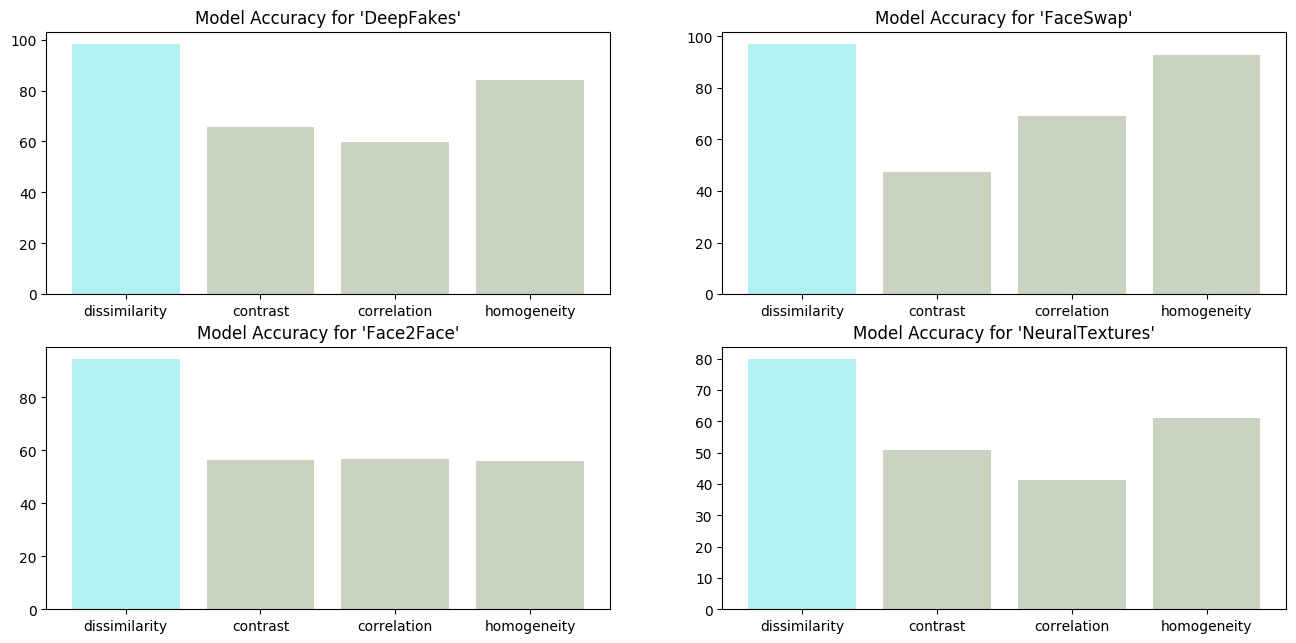

In [133]:
import matplotlib.pyplot as plt
import numpy as np

DATA_COLORS = ["darkturquoise", "darkolivegreen", "darkolivegreen", "darkolivegreen"]
metrics = [GLCM_METRIC_NAMES.dis, GLCM_METRIC_NAMES.con, GLCM_METRIC_NAMES.cor, GLCM_METRIC_NAMES.hom]
plt.figure(num=1, figsize=(16, 16), dpi=100)
i = 1
N = len(dataset_model_dict)
for k in dataset_model_dict:
  acc_per_metric = [0] * len(metrics)
  for j in range(len(metrics)):
    acc_per_metric[j] = [result.accuracy[0] for result in dataset_model_dict[k] if result.metric == metrics[j]][0]
  sp = plt.subplot(N,2,i)
  y_pos = np.arange(len(metrics))
  plt.bar(y_pos, acc_per_metric, align='center', alpha=0.3, color=DATA_COLORS[:len(metrics)])
  plt.xticks(y_pos, metrics)
  plt.title("Model Accuracy for '{}'".format(k))
  # Counter
  i += 1
plt.savefig("all_metric_acc.png",bbox_inches='tight')
plt.show()

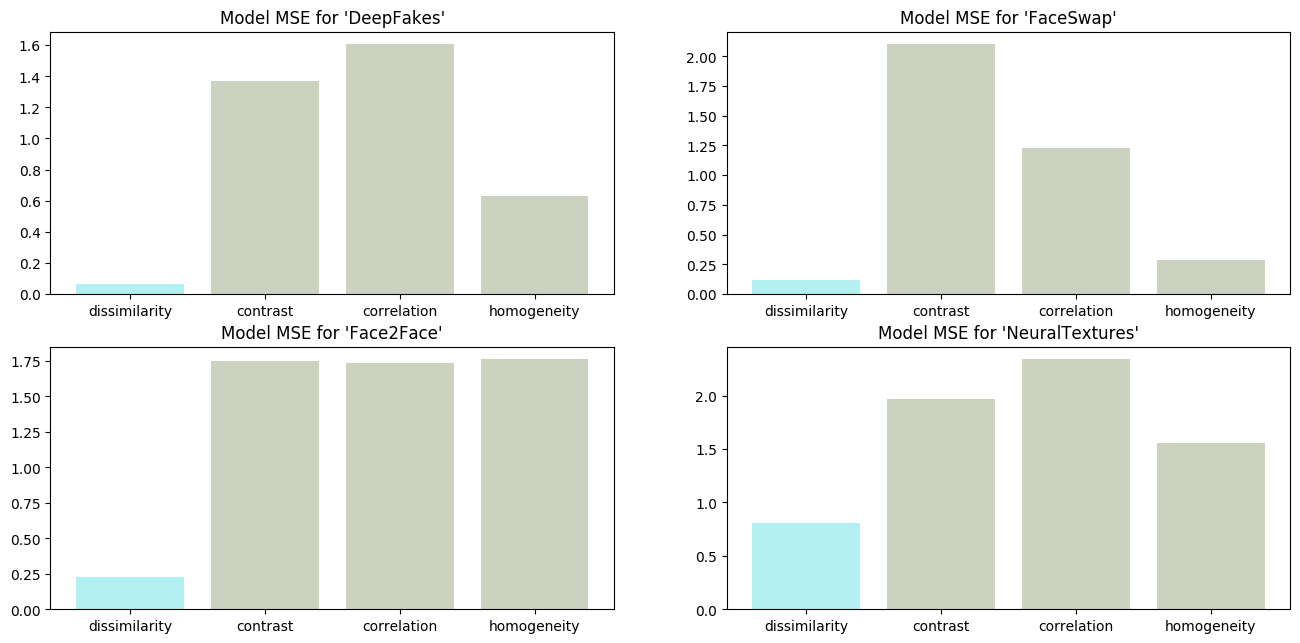

In [135]:
import matplotlib.pyplot as plt
import numpy as np

DATA_COLORS = ["darkturquoise", "darkolivegreen", "darkolivegreen", "darkolivegreen"]
metrics = [GLCM_METRIC_NAMES.dis, GLCM_METRIC_NAMES.con, GLCM_METRIC_NAMES.cor, GLCM_METRIC_NAMES.hom]
plt.figure(num=1, figsize=(16, 16), dpi=100)
i = 1
for k in dataset_model_dict:
  mse_per_metric = [0] * len(metrics)
  for j in range(len(metrics)):
    mse_per_metric[j] = [result.accuracy[1] for result in dataset_model_dict[k] if result.metric == metrics[j]][0]

  sp = plt.subplot(N,2,i)
  y_pos = np.arange(len(metrics))
  plt.bar(y_pos, mse_per_metric, align='center', alpha=0.3, color=DATA_COLORS[:len(metrics)])
  plt.xticks(y_pos, metrics)
  plt.title("Model MSE for '{}'".format(k))
  # Counter
  i += 1
plt.savefig("all_metric_mse.png",bbox_inches='tight')
plt.show()